In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
#Gerando as features que serão usadas no modelo
import sys, os
sys.path.append(os.path.abspath('..'))
from pre_processamento.processamento_dados import processamento
# --- Importações necessárias ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = processamento()
#Gerando os dados de hora e mês para situar o modelo
df['hora'] = df.index.hour
df['mes'] = df.index.month
#Gerando os lags que serão usados como features
df['lag_1'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(1)
df['lag_2'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(2)
df['lag_3'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(3)
df = df.dropna()
#Gerando os datasets de treino validação e teste
# Definindo o período de treino (2010)
train_end = '2010-12-31 23:00:00'
X_train = df[['hora', 'mes', 'lag_1', 'lag_2', 'lag_3']].loc[:train_end]
y_train = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[:train_end]
#Definindo o período de validação (2011)
val_end = '2011-12-31 23:00:00'
val_start = '2011-01-01 00:00:00'
X_val = df[['hora', 'mes', 'lag_1', 'lag_2', 'lag_3']].loc[val_start:val_end]
y_val = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[val_start:val_end]
#Definindo o período de teste (2012)
test_start = '2012-01-01 00:00:00'
X_test = df[['hora', 'mes', 'lag_1', 'lag_2', 'lag_3']].loc[test_start:]
y_test = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[test_start:]


In [3]:
X_train.head()

,hora,mes,lag_1,lag_2,lag_3
DATETIME,,,,,
2010-01-01 03:00:00,3,1,20.8,21.1,21.6
2010-01-01 04:00:00,4,1,20.5,20.8,21.1
2010-01-01 05:00:00,5,1,20.0,20.5,20.8
2010-01-01 06:00:00,6,1,19.5,20.0,20.5
2010-01-01 07:00:00,7,1,20.0,19.5,20.0


In [4]:
y_train.head()

DATETIME
2010-01-01 03:00:00    20.5
2010-01-01 04:00:00    20.0
2010-01-01 05:00:00    19.5
2010-01-01 06:00:00    20.0
2010-01-01 07:00:00    20.8
Name: TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C), dtype: float64

In [5]:
X_val.head()

,hora,mes,lag_1,lag_2,lag_3
DATETIME,,,,,
2011-01-01 00:00:00,0,1,24.1,25.2,26.8
2011-01-01 01:00:00,1,1,22.8,24.1,25.2
2011-01-01 02:00:00,2,1,22.3,22.8,24.1
2011-01-01 03:00:00,3,1,21.7,22.3,22.8
2011-01-01 04:00:00,4,1,21.4,21.7,22.3



Dados prontos! Agora o Teste contém apenas o período equivalente ao Treino.

=== 4.1 VISUALIZAÇÃO DA SÉRIE TEMPORAL ===


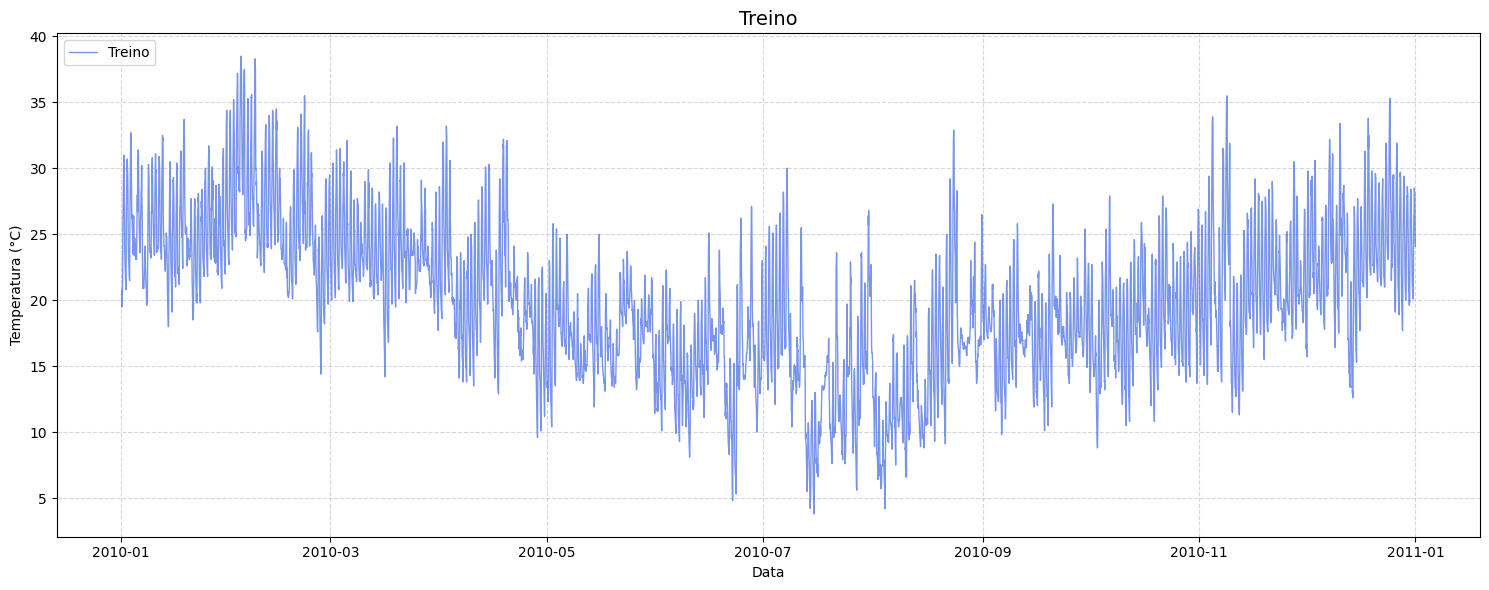

In [6]:
#Normalização
scaler = StandardScaler()

# Ajusta a régua (fit) apenas no TREINO
X_train_scaled = scaler.fit_transform(X_train)

# Aplica a régua na Validação e no Teste
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Converte de volta para DataFrame para manter colunas e índices
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index)

print("\nDados prontos! Agora o Teste contém apenas o período equivalente ao Treino.")

# ==============================================================================
# 4.1 VISUALIZAÇÃO DA DIVISÃO TEMPORAL
# ==============================================================================
print("\n=== 4.1 VISUALIZAÇÃO DA SÉRIE TEMPORAL ===")

plt.figure(figsize=(15, 6))

# 1. Plot do Treino (Azul)
plt.plot(y_train.index, y_train, label='Treino', color='royalblue', alpha=0.7, linewidth=1)

# Detalhes do Gráfico
plt.title('Treino', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

# Ajuste para não cortar datas
plt.tight_layout()
plt.show()


=== 5. MODELAGEM (Sliding-window k-fold) ===

--> Treinando por sliding-window: Random Forest...
    RMSE: 0.7432 | MAE: 0.5051 | MAPE: 2.88% | R2: 0.9840 | Coverage: 0.950 | MeanWidth: 3.035

--> Treinando por sliding-window: Gradient Boosting...
    RMSE: 0.7425 | MAE: 0.5129 | MAPE: 2.96% | R2: 0.9841 | Coverage: 0.950 | MeanWidth: 2.937

=== RANKING DE MODELOS (sliding-window) ===


,RMSE,MAE,MAPE (%),R2 Score,Tempo Treino (s),Coverage (95%),Mean PI Width
Modelo,,,,,,,
Gradient Boosting,0.742506,0.512882,2.960413,0.984080,0.588513,0.95,2.936618
Random Forest,0.743238,0.505094,2.878296,0.984049,2.214610,0.95,3.035250



>>> Re-treinando o melhor modelo (Gradient Boosting) em Train+Val para avaliar no Teste...


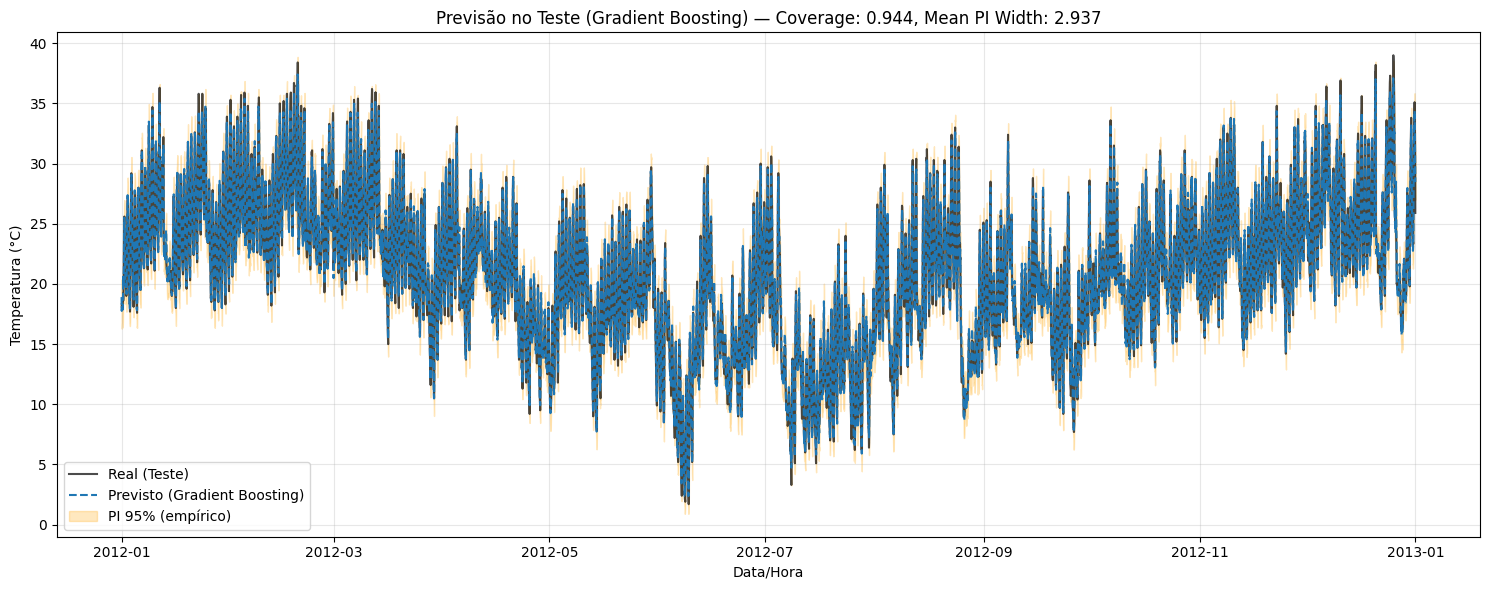

Coverage no Teste (95% empírico): 0.944
Largura média do PI no Teste: 2.937


In [7]:
# ==============================================================================
# 5. MODELAGEM E AVALIAÇÃO (Sliding-window k-fold para séries temporais)
# ==============================================================================
print("\n=== 5. MODELAGEM (Sliding-window k-fold) ===")

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Configuração dos modelos (sem GridSearch)
models_params = {
    'Random Forest': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=42))])
    },
    'Gradient Boosting': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingRegressor(random_state=42))])
    }
}

# Parâmetros do sliding-window k-fold
k = 5  # número de janelas/ folds sobre o conjunto de validação
use_expanding_train = True  # True = treino expande com janelas anteriores; False = janela de treino fixa
train_window = None  # se use_expanding_train False, defina número inteiro de passos para janela de treino

results_data = []
trained_models = {}
pi_stats = {}

# Pre-cálculo: dividir X_val / y_val em k blocos contíguos
n_val = len(X_val)
if n_val == 0:
    raise ValueError('X_val está vazio — verifique os cortes temporais')
block_size = int(np.ceil(n_val / k))

for name, cfg in models_params.items():
    print(f"\n--> Treinando por sliding-window: {name}...")
    pipeline = cfg.get('pipeline')

    fold_preds = []
    fold_trues = []
    fold_residuals = []
    fold_times = []

    for fold in range(k):
        start_idx = fold * block_size
        end_idx = min((fold + 1) * block_size, n_val)
        if start_idx >= end_idx:
            break  # sem mais blocos

        # índices do bloco de validação (no eixo temporal)
        val_index = X_val.index[start_idx:end_idx]

        # Construir conjunto de treino para este fold
        if use_expanding_train:
            # treino = X_train + X_val anteriores ao bloco atual
            if start_idx == 0:
                X_train_fold = X_train.copy()
                y_train_fold = y_train.copy()
            else:
                X_train_fold = pd.concat([X_train, X_val.iloc[:start_idx]])
                y_train_fold = pd.concat([y_train, y_val.iloc[:start_idx]])
        else:
            # janela fixa antes do bloco de validação
            # combinamos train+val para poder tomar a janela imediatamente anterior ao bloco
            combined_X = pd.concat([X_train, X_val])
            combined_y = pd.concat([y_train, y_val])
            # posição inicial do bloco no combined
            combined_start = len(X_train) + start_idx
            train_start = max(0, combined_start - train_window)
            train_end = combined_start
            X_train_fold = combined_X.iloc[train_start:train_end]
            y_train_fold = combined_y.iloc[train_start:train_end]

        # Treina o pipeline neste fold
        t0 = time.time()
        pipeline.fit(X_train_fold, y_train_fold)
        fold_times.append(time.time() - t0)

        # Previsão no bloco de validação
        y_pred_fold = pipeline.predict(X_val.loc[val_index])
        y_true_fold = y_val.loc[val_index]

        fold_preds.append(pd.Series(y_pred_fold, index=val_index))
        fold_trues.append(y_true_fold)
        # garantir resíduos como Series com índice correto
        fold_residuals.append(pd.Series(y_true_fold.values - y_pred_fold, index=val_index))

    # Concatena resultados dos folds
    if len(fold_preds) == 0:
        print('Nenhum fold executado para', name)
        continue

    y_pred_all = pd.concat(fold_preds).sort_index()
    y_true_all = pd.concat(fold_trues).sort_index()
    # concatena resíduos preservando índices
    residuals_all = pd.concat(fold_residuals).sort_index()

    # Métricas agregadas sobre todos os folds
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
    mae = mean_absolute_error(y_true_all, y_pred_all)
    mape = mean_absolute_percentage_error(y_true_all, y_pred_all) * 100
    r2 = r2_score(y_true_all, y_pred_all)
    avg_train_time = np.mean(fold_times) if fold_times else None

    # PI empírico a partir dos resíduos agregados (usar .values para quantil)
    lower_q, upper_q = np.quantile(residuals_all.values, [0.025, 0.975])
    lower_all = y_pred_all + lower_q
    upper_all = y_pred_all + upper_q
    coverage = np.mean((y_true_all >= lower_all) & (y_true_all <= upper_all))
    mean_width = np.mean(upper_all - lower_all)

    # Guarda stats e modelo (armazena o pipeline treinado no último fold)
    pi_stats[name] = {'lower_q': float(lower_q), 'upper_q': float(upper_q)}
    trained_models[name] = pipeline

    results_data.append({
        'Modelo': name,
        'RMSE': float(rmse),
        'MAE': float(mae),
        'MAPE (%)': float(mape),
        'R2 Score': float(r2),
        'Tempo Treino (s)': float(avg_train_time) if avg_train_time is not None else None,
        'Coverage (95%)': float(coverage),
        'Mean PI Width': float(mean_width)
    })

    print(f"    RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f} | Coverage: {coverage:.3f} | MeanWidth: {mean_width:.3f}")

# Exibe ranking
# define o índice como o nome do modelo para facilitar lookup posterior
df_results = pd.DataFrame(results_data).set_index('Modelo').sort_values(by='RMSE')
print("\n=== RANKING DE MODELOS (sliding-window) ===")
from IPython.display import display

display(df_results)

# Re-treinar o melhor modelo em todo o conjunto de treino+val (para previsão no teste)
best_name = df_results['RMSE'].idxmin()
best_pipeline = trained_models[best_name]
print(f"\n>>> Re-treinando o melhor modelo ({best_name}) em Train+Val para avaliar no Teste...")
combined_X_train = pd.concat([X_train, X_val])
combined_y_train = pd.concat([y_train, y_val])
best_pipeline.fit(combined_X_train, combined_y_train)

# Previsão final no Teste (garantir Series alinhada ao índice de X_test)
y_final = pd.Series(best_pipeline.predict(X_test), index=X_test.index)

# PI no teste usando quantis empíricos obtidos nos folds
stats = pi_stats.get(best_name)
if stats is not None:
    lower_q = stats['lower_q']
    upper_q = stats['upper_q']
else:
    # calcular std do erro no conjunto combinado (usar Series alinhada)
    train_pred_combined = pd.Series(best_pipeline.predict(combined_X_train), index=combined_X_train.index)
    err_std = np.std((combined_y_train - train_pred_combined).values)
    lower_q = -1.96 * err_std
    upper_q = 1.96 * err_std

lower_test = y_final + lower_q
upper_test = y_final + upper_q
coverage_test = np.mean((y_test >= lower_test) & (y_test <= upper_test))
mean_width_test = np.mean((upper_test - lower_test).values)

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Real (Teste)', color='black', linewidth=1.5, alpha=0.7)
plt.plot(y_test.index, y_final, label=f'Previsto ({best_name})', linestyle='--', linewidth=1.5)
# passar arrays para fill_between (mesma ordem que y_test.index)
plt.fill_between(y_test.index, lower_test.values, upper_test.values, color='orange', alpha=0.25, label='PI 95% (empírico)')
plt.title(f'Previsão no Teste ({best_name}) — Coverage: {coverage_test:.3f}, Mean PI Width: {mean_width_test:.3f}')
plt.xlabel('Data/Hora')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Coverage no Teste (95% empírico): {coverage_test:.3f}")
print(f"Largura média do PI no Teste: {mean_width_test:.3f}")



>>> CAMPEÃO: Gradient Boosting
>>> R2 Score: 0.9841


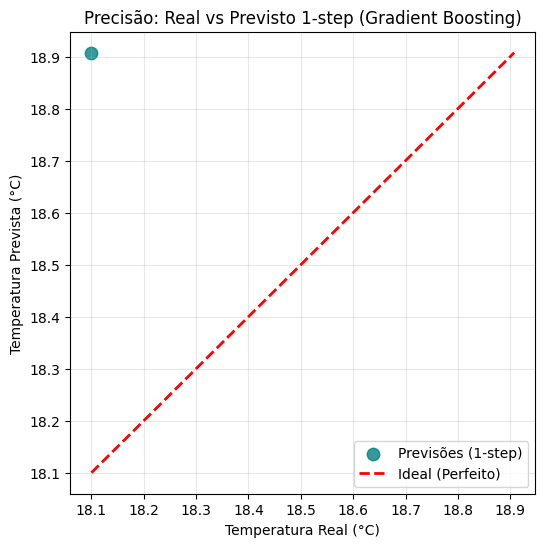

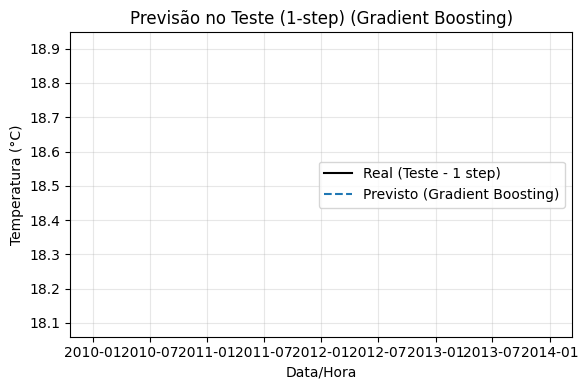

Índice previsto: 2012-01-01 00:00:00
Valor real: 18.100
Valor previsto (1-step): 18.907


In [ ]:
# 3. Identificação do Melhor Modelo (sem Intervalos de Confiança)
# agora df_results está indexado por 'Modelo'
best_name = df_results['R2 Score'].idxmax()
best_model_pipeline = trained_models[best_name]
print(f"\n>>> CAMPEÃO: {best_name}")
print(f">>> R2 Score: {df_results.loc[best_name, 'R2 Score']:.4f}")

# 4. Previsão 1-step no Teste (apenas a primeira amostra de X_test)
if len(X_test) == 0:
    raise ValueError('X_test está vazio — nada a prever')

X_test_first = X_test.iloc[[0]]
y_test_first = y_test.iloc[[0]]

# previsão 1-step
y_final = best_model_pipeline.predict(X_test_first)

# --- Métricas de avaliação para a predição 1-step ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

y_true_arr = y_test_first.values.flatten()
y_pred_arr = np.atleast_1d(y_final).flatten()

rmse_1step = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr))
mae_1step = mean_absolute_error(y_true_arr, y_pred_arr)
# MAPE pode lançar erro/dividir por zero para valor real 0
try:
    mape_1step = mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100
except Exception:
    mape_1step = float('nan')
# R2 precisa de >=2 amostras; tratar caso de 1 amostra
try:
    r2_1step = r2_score(y_true_arr, y_pred_arr)
except Exception:
    r2_1step = float('nan')

print("\n=== MÉTRICAS 1-step (Teste) ===")
print(f"RMSE (1-step): {rmse_1step:.4f}")
print(f"MAE (1-step): {mae_1step:.4f}")
if np.isfinite(mape_1step):
    print(f"MAPE (1-step): {mape_1step:.2f}%")
else:
    print("MAPE (1-step): N/A")
if np.isfinite(r2_1step):
    print(f"R2 (1-step): {r2_1step:.4f}")
else:
    print("R2 (1-step): N/A (menos de 2 amostras)")

# Exibir valores individuais já existentes
print(f"\nÍndice previsto: {y_test_first.index[0]}")
print(f"Valor real: {y_test_first.values[0]:.3f}")
print(f"Valor previsto (1-step): {y_pred_arr[0]:.3f}")
